In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lifetimes
import seaborn as sns 
import math

In [2]:
df = pd.read_parquet("transactional_dataset_train.parquet")

In [3]:
df.head()

,account_id,event_time,amount
0,132285932,2021-08-14 21:18:04.956,19.99
1,131792942,2021-08-14 21:28:33.266,9.99
2,180084640,2021-08-14 19:10:59.833,0.99
3,132486244,2021-08-14 20:35:14.897,9.99
4,131970262,2021-08-14 19:30:59.234,0.99


In [4]:
df["amount"].describe()

count    161075.000000
mean          5.941833
std           9.208794
min           0.990000
25%           1.990000
50%           2.990000
75%           4.990000
max          99.990000
Name: amount, dtype: float64

# Dataset overview

In [5]:
maxdate = df["event_time"].dt.date.max()
mindate = df["event_time"].dt.date.min()
number_of_unique_customers = df["account_id"].nunique()
total_spend = df["amount"].sum()

print(f"Time range of all transactions is from {mindate} to {maxdate}")
print(f"Total number of unique ID: {number_of_unique_customers}")
print(f"Total spend is: {total_spend}")  

Time range of all transactions is from 2021-02-02 to 2021-08-20
Total number of unique ID: 69858
Total spend is: 957080.7100000001


# Historical approach

In [6]:
CLV_Historic = df.groupby("account_id").agg({"event_time": lambda x: (df["event_time"].max()-x.max()).days,
                                            "account_id": lambda x: len(x),
                                            "amount": lambda x: sum(x)})

In [7]:
CLV_Historic.columns = ["Age","Frequency","Total_amount"]
CLV_Historic.sort_values(by="Frequency",ascending=False)
CLV_Historic["type_of_buyer"] = np.where(CLV_Historic["Frequency"]==1,"One_time","more_than_one")
CLV_Historic["count"] = np.where(CLV_Historic["type_of_buyer"]=="One_time",1,0)


In [8]:
ln_Total=[]
for i in range(0,len(CLV_Historic["Total_amount"])):
    ln_Total.append(math.log(CLV_Historic["Total_amount"][i]))
    
CLV_Historic["Ln_Total_Amount"]=ln_Total

In [9]:
ln_Total_F=[]
for i in range(0,len(CLV_Historic["Frequency"])):
    ln_Total_F.append(math.log(CLV_Historic["Frequency"][i]))
    
CLV_Historic["Ln_Frequency"]=ln_Total_F

In [10]:
CLV_Historic.sort_values(by="Frequency",ascending = False).head()

,Age,Frequency,Total_amount,type_of_buyer,count,Ln_Total_Amount,Ln_Frequency
account_id,,,,,,,
98491143,174,104,2756.96,more_than_one,0,7.921884,4.644391
167529481,57,97,1214.03,more_than_one,0,7.101701,4.574711
113958422,84,89,2655.11,more_than_one,0,7.884241,4.488636
169616730,47,83,2854.17,more_than_one,0,7.956536,4.418841
123433842,41,81,735.19,more_than_one,0,6.600129,4.394449


In [11]:
CLV_Historic_one_time_buyers = CLV_Historic[CLV_Historic["count"]==1]
CLV_Historic_one_time_buyers.sort_values(by="Total_amount",ascending=False).head()

,Age,Frequency,Total_amount,type_of_buyer,count,Ln_Total_Amount,Ln_Frequency
account_id,,,,,,,
130423134,12,1,99.99,One_time,1,4.60507,0.0
99779802,160,1,99.99,One_time,1,4.60507,0.0
157045881,104,1,99.99,One_time,1,4.60507,0.0
151135420,128,1,99.99,One_time,1,4.60507,0.0
129463743,17,1,99.99,One_time,1,4.60507,0.0


In [12]:
CLV_Historic_only_more_than_one = CLV_Historic[CLV_Historic["count"]!=1]
CLV_Historic_only_more_than_one.sort_values(by="Total_amount",ascending=False).head()

,Age,Frequency,Total_amount,type_of_buyer,count,Ln_Total_Amount,Ln_Frequency
account_id,,,,,,,
169616730,47,83,2854.17,more_than_one,0,7.956536,4.418841
98491143,174,104,2756.96,more_than_one,0,7.921884,4.644391
113958422,84,89,2655.11,more_than_one,0,7.884241,4.488636
125162993,34,80,1984.20,more_than_one,0,7.592971,4.382027
101436153,144,56,1891.44,more_than_one,0,7.545094,4.025352


In [13]:
print(CLV_Historic_one_time_buyers["Total_amount"].describe(percentiles = [.25,.5,.99]))
print("repetitive")
print(CLV_Historic_only_more_than_one["Total_amount"].describe(percentiles = [.25,.5,.95]))
print(CLV_Historic["Total_amount"].describe(percentiles = [.25,.5,.99]))
print(CLV_Historic["Total_amount"].describe())

count    39865.000000
mean         3.247722
std          4.699702
min          0.990000
25%          0.990000
50%          2.990000
99%         19.990000
max         99.990000
Name: Total_amount, dtype: float64
repetitive
count    29993.000000
mean        27.593447
std         64.767596
min          1.980000
25%          5.980000
50%         12.940000
95%         91.954000
max       2854.170000
Name: Total_amount, dtype: float64
count    69858.000000
mean        13.700374
std         44.258498
min          0.990000
25%          1.990000
50%          3.980000
99%        151.928600
max       2854.170000
Name: Total_amount, dtype: float64
count    69858.000000
mean        13.700374
std         44.258498
min          0.990000
25%          1.990000
50%          3.980000
75%          9.990000
max       2854.170000
Name: Total_amount, dtype: float64


<AxesSubplot:xlabel='Total_amount', ylabel='Density'>

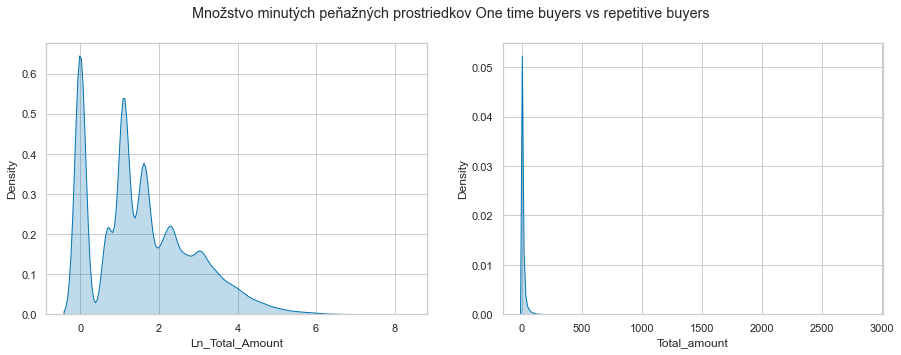

In [44]:
# grafy s vyuzitim logaritmickej skaly pomocou prirodzeneho logaritmu
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=False,sharex=False)
fig.suptitle('Množstvo minutých peňažných prostriedkov One time buyers vs repetitive buyers')
sns.set_theme(style="whitegrid",palette="colorblind")
sns.kdeplot(x=CLV_Historic["Ln_Total_Amount"],ax=axes[0],fill=True) # more than one times
sns.kdeplot(x=CLV_Historic[""],fill=True,ax=axes[1])

<AxesSubplot:xlabel='Ln_Total_Amount', ylabel='Density'>

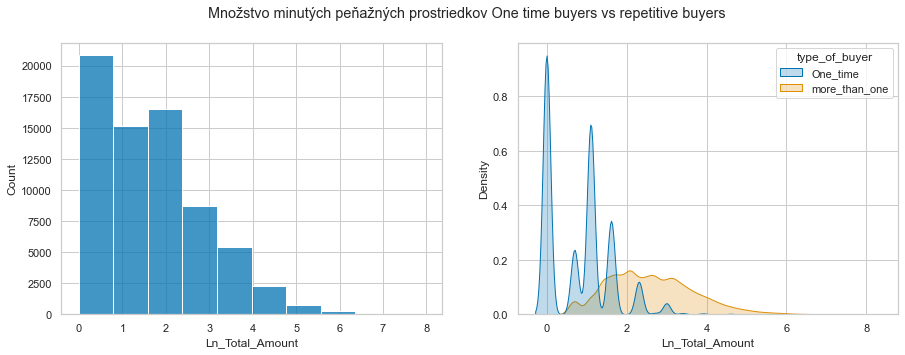

In [15]:
# grafy s vyuzitim logaritmickej skaly pomocou prirodzeneho logaritmu
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=False,sharex=False)
fig.suptitle('Množstvo minutých peňažných prostriedkov One time buyers vs repetitive buyers')
sns.set_theme(style="whitegrid",palette="colorblind")
sns.histplot(x=CLV_Historic["Ln_Total_Amount"],ax=axes[0],bins=10) # all buyers
sns.kdeplot(x=CLV_Historic["Ln_Total_Amount"],ax=axes[1],fill=True,hue=CLV_Historic["type_of_buyer"])

<AxesSubplot:xlabel='Ln_Total_Amount', ylabel='Count'>

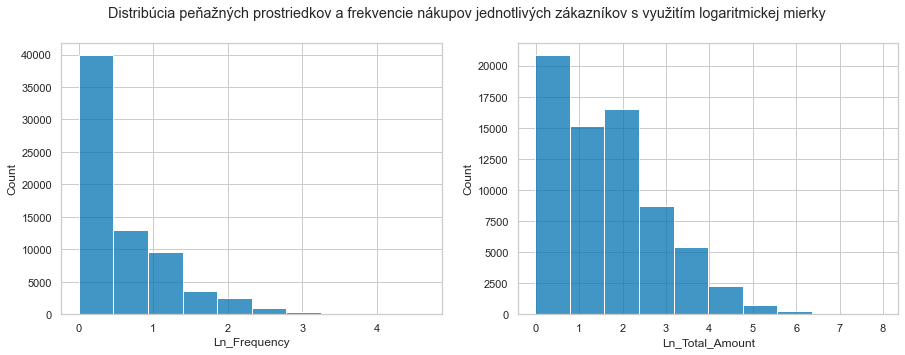

In [59]:
# grafy s vyuzitim logaritmickej skaly pomocou prirodzeneho logaritmu
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=False,sharex=False)
fig.suptitle('Distribúcia peňažných prostriedkov a frekvencie nákupov jednotlivých zákazníkov s využitím logaritmickej mierky')
sns.set_theme(style="whitegrid",palette="colorblind")
sns.histplot(x=CLV_Historic["Ln_Frequency"],ax=axes[0],bins=10) # all buyers
sns.histplot(x=CLV_Historic["Ln_Total_Amount"],ax=axes[1],bins=10)

<AxesSubplot:xlabel='Ln_Total_Amount', ylabel='Count'>

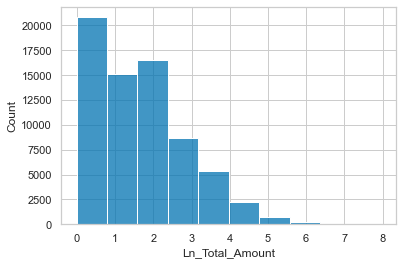

In [61]:
sns.set_theme(style="whitegrid",palette="colorblind")
sns.histplot(x=CLV_Historic["Ln_Total_Amount"],bins=10)

<AxesSubplot:ylabel='Total_amount'>

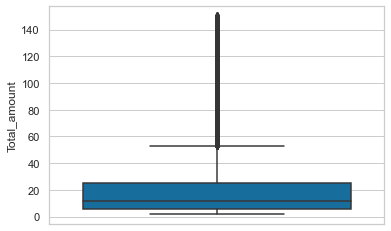

In [16]:
sns.boxplot(y=CLV_Historic_only_more_than_one["Total_amount"][CLV_Historic_only_more_than_one["Total_amount"]<150])

In [17]:
Average_amount = round(np.mean(CLV_Historic.Total_amount),2)
print(f"Average_amount: {Average_amount}")

Frequency = round(np.mean(CLV_Historic.Frequency),2)
print(f"Average Frequency: {Frequency}")

Retention_rate = CLV_Historic[CLV_Historic["Frequency"]>1].shape[0]/CLV_Historic.shape[0]
churn = round(1-Retention_rate,2)
print(f"Retention rate: {round(Retention_rate*100,2)}%")
print(f"Churn rate: {round(churn*100,2)}%")

Average_amount: 13.7
Average Frequency: 2.31
Retention rate: 42.93%
Churn rate: 57.0%


In [18]:
Profit_margin = 0.05

CLV = round((Average_amount*Frequency/churn)*Profit_margin,2)
print(f"customer lifetime value: {CLV}")

customer lifetime value: 2.78


In [19]:
CLV_Historic["Frequency"].describe(percentiles  = [.25,.5,.99])

count    69858.000000
mean         2.305749
std          2.965724
min          1.000000
25%          1.000000
50%          1.000000
99%         14.000000
max        104.000000
Name: Frequency, dtype: float64

In [20]:
CLV_Historic["Total_amount"].describe(percentiles = [.25,.5,.99])

count    69858.000000
mean        13.700374
std         44.258498
min          0.990000
25%          1.990000
50%          3.980000
99%        151.928600
max       2854.170000
Name: Total_amount, dtype: float64

# Cohort model with cut and qcut

In [21]:
CLV_Cohort = CLV_Historic

In [22]:
CLV_Cohort.head()

,Age,Frequency,Total_amount,type_of_buyer,count,Ln_Total_Amount,Ln_Frequency
account_id,,,,,,,
100000423,159,1,9.99,One_time,1,2.301585,0.000000
100001374,158,1,2.99,One_time,1,1.095273,0.000000
100001463,160,1,0.99,One_time,1,-0.010050,0.000000
100001654,160,3,6.99,more_than_one,0,1.944481,1.098612
100003092,158,1,0.99,One_time,1,-0.010050,0.000000


In [23]:
bins_range = [0.99,20,50,104]
bins_labels = ["basic","advanced","pro"]

In [24]:
CLV_Cohort["level"] = pd.cut(CLV_Cohort["Frequency"],bins = bins_range,labels = bins_labels)

In [25]:
pd.qcut(CLV_Cohort["Total_amount"],q=4).value_counts() # rovnomerne tozlozenie hracov 

(0.989, 1.99]      20711
(9.99, 2854.17]    17418
(3.98, 9.99]       16522
(1.99, 3.98]       15207
Name: Total_amount, dtype: int64

In [26]:
iterate = ["basic","advanced","pro"] 
Cohorts_CLV=[]
for i in range(0,3):
    customer_m = CLV_Cohort[CLV_Cohort["level"]==iterate[i]]
    
    average_sales = round(np.mean(customer_m["Total_amount"]),2)
    
    Purchase_frequency = round(np.mean(customer_m["Frequency"]),2)
    
    Retention_rate = customer_m[customer_m["Frequency"]>1].shape[0]/customer_m.shape[0]
    print(f"reteniton rate {Retention_rate}")
    print(f"number of repetitive buyers {customer_m[customer_m['Frequency']>1].shape[0]}")
    print(f"number of all buyers in this cohort{customer_m.shape[0]}")
    churn = 1 - Retention_rate
    
    CLV = round(((average_sales*Purchase_frequency/churn))*Profit_margin,2)
    
    Cohorts_CLV.append(CLV)
                                

reteniton rate 0.42722701149425285
number of repetitive buyers 29735
number of all buyers in this cohort69600
reteniton rate 1.0
number of repetitive buyers 241
number of all buyers in this cohort241
reteniton rate 1.0
number of repetitive buyers 17
number of all buyers in this cohort17


C:\Users\fpolo\AppData\Local\Temp/ipykernel_25868/1151116213.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  CLV = round(((average_sales*Purchase_frequency/churn))*Profit_margin,2)


# Cohort model with months 

In [27]:
customer = df.groupby("account_id").agg({"event_time": lambda x: x.min().month,
                                         "account_id": lambda x: len(x),
                                         "amount": lambda x: np.sum(x)})
                                        
customer.columns = ["Start_month", "Frequency", "Total_amount"]

customer

,Start_month,Frequency,Total_amount
account_id,,,
100000423,3,1,9.99
100001374,3,1,2.99
100001463,3,1,0.99
100001654,3,3,6.99
100003092,3,1,0.99
...,...,...,...
99995053,3,2,22.98
99995304,3,2,12.98
99996154,3,1,2.99


In [28]:
CLV_monthly = []

for i in range(2,9):
    customer_m = customer[customer["Start_month"]==i]

    Average_sales = np.mean(customer_m["Total_amount"])
    
    Purchase_frequency = np.mean(customer_m["Frequency"])
                                            
    Retention_rate = customer_m[customer_m["Frequency"]>1].shape[0]/customer_m.shape[0]
    churn_rate = 1-Retention_rate
    
    CLV=round((Average_sales*Purchase_frequency/churn_rate)*Profit_margin,2)
                                 
    CLV_monthly.append(CLV)

In [29]:
CLV_monthly

[2.95, 2.61, 2.93, 2.58, 2.47, 2.9, 2.91]

In [30]:
months=["Február","Marec","Apríl","Máj","Jún","Júl","August"]

In [31]:
print(pd.DataFrame(zip(months,CLV_monthly),columns = ["Mesiac","CLV"]))

    Mesiac   CLV
0  Február  2.95
1    Marec  2.61
2    Apríl  2.93
3      Máj  2.58
4      Jún  2.47
5      Júl  2.90
6   August  2.91


<AxesSubplot:xlabel='[Február, Marec, Apríl, Máj, Jún, Júl, August]'>

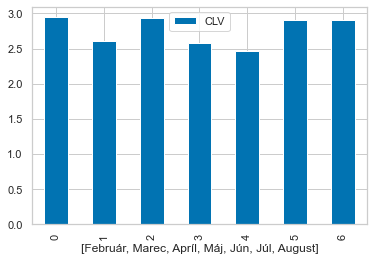

In [32]:
histogram = pd.DataFrame(zip(months,CLV_monthly),columns = ["Mesiac","CLV"])
histogram.plot(kind="bar",xlabel=histogram["Mesiac"])

# Lifetime package 

In [33]:
summary = lifetimes.utils.summary_data_from_transaction_data(df,"account_id","event_time","amount",freq='s',freq_multiplier=86400)
summary = summary.reset_index()

In [34]:
summary.sort_values(by="frequency",ascending = False)

,account_id,frequency,recency,T,monetary_value
67223,98491143,103.0,2.189190,176.550914,26.718155
50591,167529481,96.0,2.891840,60.774086,12.594167
10480,113958422,88.0,1.664942,86.127986,30.058182
52280,169616730,82.0,2.894387,50.590313,34.770488
19734,123433842,80.0,2.371910,43.490475,9.152500
...,...,...,...,...,...
29364,129610414,0.0,0.000000,16.880255,0.000000
29366,129610564,0.0,0.000000,16.507118,0.000000
29370,129611652,0.0,0.000000,15.681123,0.000000
29375,129612734,0.0,0.000000,16.873623,0.000000


count    69858.000000
mean         1.304604
std          2.965060
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max        103.000000
Name: frequency, dtype: float64
percentage of one time buyers 18.64


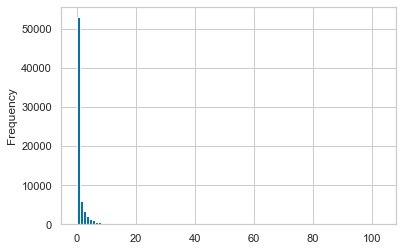

In [35]:
summary["frequency"].plot(kind="hist",bins = 100)
print(summary["frequency"].describe())
percentage = sum(summary["frequency"]==1)/(len(summary))*(100)
print(f"percentage of one time buyers { round(percentage,2)}")

In [36]:
bgf = lifetimes.BetaGeoFitter()
bgf.fit(summary["frequency"],summary["recency"],summary["T"])

<lifetimes.BetaGeoFitter: fitted with 69858 subjects, a: 2.93, alpha: 0.00, b: 4.07, r: 0.06>

In [37]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.060864,0.000412,0.060056,0.061672
alpha,0.003070,0.000080,0.002912,0.003228
a,2.929621,0.070903,2.790650,3.068591
b,4.067368,0.124858,3.822647,4.312090


c:\users\fpolo\appdata\local\programs\python\python39\lib\site-packages\lifetimes\fitters\beta_geo_fitter.py:256: RuntimeWarning: overflow encountered in double_scalars
  denominator = 1 + (x > 0) * (a / (b + x - 1)) * ((alpha + T) / (alpha + recency)) ** (r + x)


<AxesSubplot:title={'center':'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

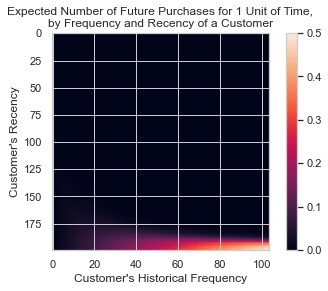

In [38]:
from lifetimes.plotting import plot_frequency_recency_matrix

plot_frequency_recency_matrix(bgf)

In [39]:
summary["probability_alive"] = bgf.conditional_probability_alive(summary["frequency"],summary["recency"],summary["T"])
summary.sort_values(by="probability_alive",ascending = True)

,account_id,frequency,recency,T,monetary_value,probability_alive
67223,98491143,103.0,2.189190,176.550914,26.718155,1.337390e-195
10480,113958422,88.0,1.664942,86.127986,30.058182,4.443897e-150
50591,167529481,96.0,2.891840,60.774086,12.594167,3.361596e-126
36702,143169930,54.0,1.905382,197.708056,8.656667,2.177814e-108
42053,149812631,57.0,1.911285,139.210417,9.235614,1.213283e-105
...,...,...,...,...,...,...
29366,129610564,0.0,0.000000,16.507118,0.000000,1.000000e+00
29370,129611652,0.0,0.000000,15.681123,0.000000,1.000000e+00
29375,129612734,0.0,0.000000,16.873623,0.000000,1.000000e+00
29382,129616472,0.0,0.000000,13.379062,0.000000,1.000000e+00


<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

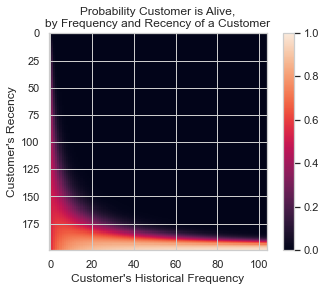

In [40]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)

<AxesSubplot:title={'center':'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

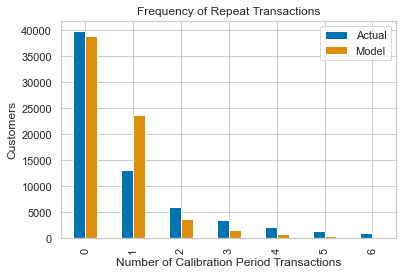

In [41]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)